In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import pandas as pd

df_augmented = pd.read_csv("augmented_SDSS.csv")

if 'label' not in df_augmented.columns:
    label_map = {'STAR': 0, 'GALAXY': 1, 'QSO': 2}
    df_augmented['label'] = df_augmented['class'].map(label_map)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("🔥 Using device:", device)

features_to_use = [
    'u', 'g', 'r', 'i', 'z',
    'petroRad_u', 'petroRad_g', 'petroRad_r', 'petroRad_i', 'petroRad_z',
    'petroFlux_u', 'petroFlux_g', 'petroFlux_r', 'petroFlux_i', 'petroFlux_z',
    'petroR50_u', 'petroR50_g', 'petroR50_r', 'petroR50_i', 'petroR50_z',
    'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z',
    'expAB_u', 'expAB_g', 'expAB_r', 'expAB_i', 'expAB_z',
    'redshift'
]

X = df_augmented[features_to_use].values
y = df_augmented['label'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

train_data = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
val_data = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=128)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden1=128, hidden2=64, output_dim=3):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden2, output_dim)
        )

    def forward(self, x):
        return self.net(x)

model = MLP(input_dim=X.shape[1]).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

checkpoint_path = "mlp_sdss_checkpoint.pth"
start_epoch = 0

if os.path.exists(checkpoint_path):
    print("📦 Resuming from checkpoint...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"🔁 Resuming from epoch {start_epoch}")

EPOCHS = 20
for epoch in range(start_epoch, EPOCHS):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb)
            pred_labels = torch.argmax(preds, dim=1)
            correct += (pred_labels == yb).sum().item()
            total += yb.size(0)

    acc = correct / total
    print(f"📚 Epoch {epoch+1}/{EPOCHS} - Loss: {total_loss:.4f} - Val Accuracy: {acc:.4f}")

    #Save model
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, checkpoint_path)
    print("💾 Model saved.")

🔥 Using device: cuda
📚 Epoch 1/20 - Loss: 139.9208 - Val Accuracy: 0.9842
💾 Model saved.
📚 Epoch 2/20 - Loss: 71.4296 - Val Accuracy: 0.9860
💾 Model saved.
📚 Epoch 3/20 - Loss: 63.2611 - Val Accuracy: 0.9861
💾 Model saved.
📚 Epoch 4/20 - Loss: 59.2987 - Val Accuracy: 0.9867
💾 Model saved.
📚 Epoch 5/20 - Loss: 56.0890 - Val Accuracy: 0.9865
💾 Model saved.
📚 Epoch 6/20 - Loss: 54.2340 - Val Accuracy: 0.9867
💾 Model saved.
📚 Epoch 7/20 - Loss: 52.7763 - Val Accuracy: 0.9874
💾 Model saved.
📚 Epoch 8/20 - Loss: 51.4176 - Val Accuracy: 0.9879
💾 Model saved.
📚 Epoch 9/20 - Loss: 49.6759 - Val Accuracy: 0.9883
💾 Model saved.
📚 Epoch 10/20 - Loss: 49.0736 - Val Accuracy: 0.9880
💾 Model saved.
📚 Epoch 11/20 - Loss: 48.6172 - Val Accuracy: 0.9879
💾 Model saved.
📚 Epoch 12/20 - Loss: 47.8888 - Val Accuracy: 0.9882
💾 Model saved.
📚 Epoch 13/20 - Loss: 46.6733 - Val Accuracy: 0.9884
💾 Model saved.
📚 Epoch 14/20 - Loss: 46.8224 - Val Accuracy: 0.9884
💾 Model saved.
📚 Epoch 15/20 - Loss: 46.0298 - Val

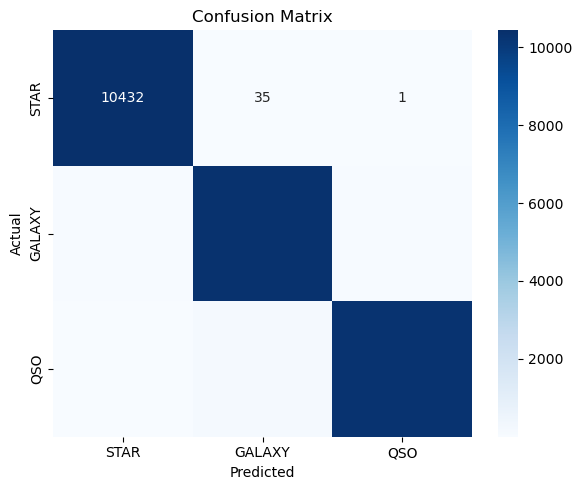

🛠️ Saved misclassified samples to 'wrong_predictions.csv'


In [8]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# === Load Data
df = pd.read_csv("augmented_SDSS.csv")
df['label'] = df['label'].astype(int)

features = [
    'u', 'g', 'r', 'i', 'z',
    'petroRad_u', 'petroRad_g', 'petroRad_r', 'petroRad_i', 'petroRad_z',
    'petroFlux_u', 'petroFlux_g', 'petroFlux_r', 'petroFlux_i', 'petroFlux_z',
    'petroR50_u', 'petroR50_g', 'petroR50_r', 'petroR50_i', 'petroR50_z',
    'psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z',
    'expAB_u', 'expAB_g', 'expAB_r', 'expAB_i', 'expAB_z',
    'redshift'
]
X = df[features].values
y = df['label'].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden1=128, hidden2=64, output_dim=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden2, output_dim)
        )
    def forward(self, x):
        return self.net(x)

model = MLP(input_dim=X_val.shape[1])
checkpoint = torch.load(r"C:\Users\kuzey\OneDrive\Masaüstü\fizik_proje\Multi_layer_Perceptron_classifier.pth", map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
with torch.no_grad():
    outputs = model(X_val_tensor)
    preds = torch.argmax(outputs, dim=1).numpy()

cm = confusion_matrix(y_val, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['STAR', 'GALAXY', 'QSO'],
            yticklabels=['STAR', 'GALAXY', 'QSO'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

report = classification_report(y_val, preds, target_names=['STAR', 'GALAXY', 'QSO'], output_dict=True)
report_df = pd.DataFrame(report).T
print(report_df)

wrong_idx = np.where(preds != y_val)[0]
wrong_cases = pd.DataFrame(X_val[wrong_idx], columns=features)
wrong_cases['true'] = y_val[wrong_idx]
wrong_cases['pred'] = preds[wrong_idx]
wrong_cases.to_csv("wrong_predictions.csv", index=False)
print("🛠️ Saved misclassified samples to 'wrong_predictions.csv'")


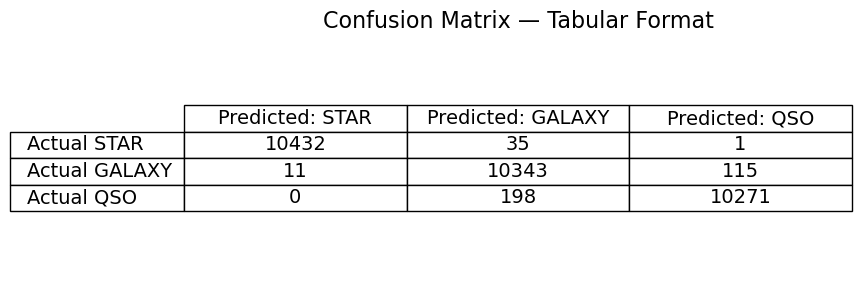

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

confusion_data = {
    "Predicted: STAR": [10432, 11, 0],
    "Predicted: GALAXY": [35, 10343, 198],
    "Predicted: QSO": [1, 115, 10271]
}
index_labels = ["Actual STAR", "Actual GALAXY", "Actual QSO"]
df_matrix = pd.DataFrame(confusion_data, index=index_labels)

fig, ax = plt.subplots(figsize=(9, 3))
ax.axis('off')

table = ax.table(cellText=df_matrix.values,
                 rowLabels=df_matrix.index,
                 colLabels=df_matrix.columns,
                 loc='center',
                 cellLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1.2, 1.5)

plt.title("Confusion Matrix — Tabular Format", fontsize=16)
plt.tight_layout()
plt.show()


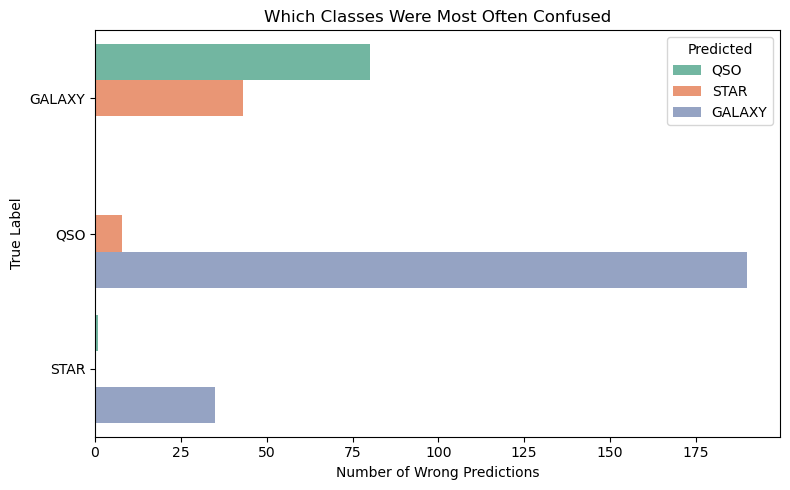

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_wrong = pd.read_csv(r"C:\Users\kuzey\OneDrive\Masaüstü\fizik_proje\wrong_predictions.csv")

label_map = {0: "STAR", 1: "GALAXY", 2: "QSO"}
df_wrong["true_name"] = df_wrong["true"].map(label_map)
df_wrong["pred_name"] = df_wrong["pred"].map(label_map)

confusion_pairs = df_wrong.groupby(["true_name", "pred_name"]).size().reset_index(name='count')

plt.figure(figsize=(8, 5))
sns.barplot(data=confusion_pairs, x='count', y='true_name', hue='pred_name', palette='Set2')
plt.title("Which Classes Were Most Often Confused")
plt.xlabel("Number of Wrong Predictions")
plt.ylabel("True Label")
plt.legend(title="Predicted")
plt.tight_layout()
plt.show()


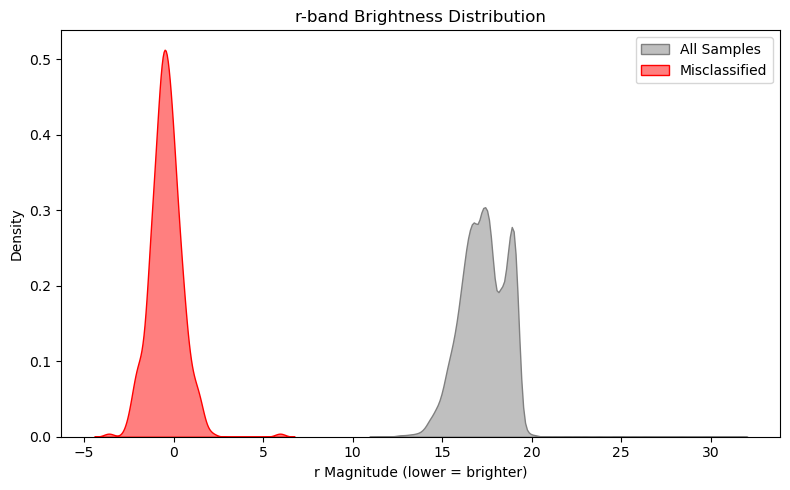

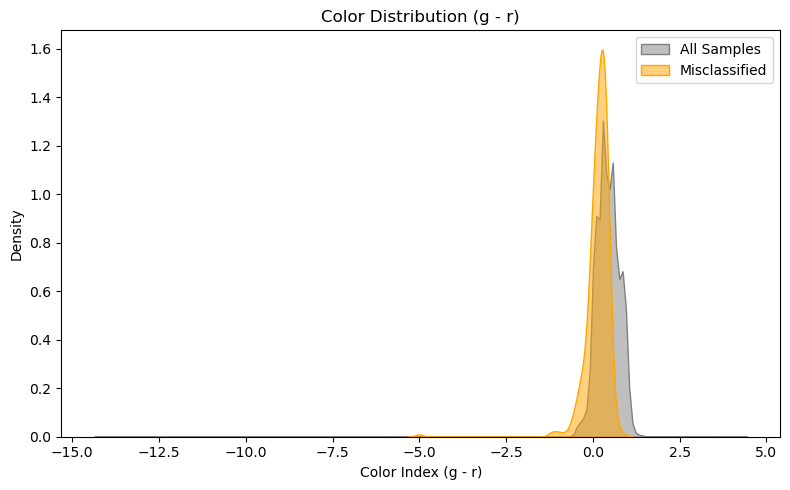

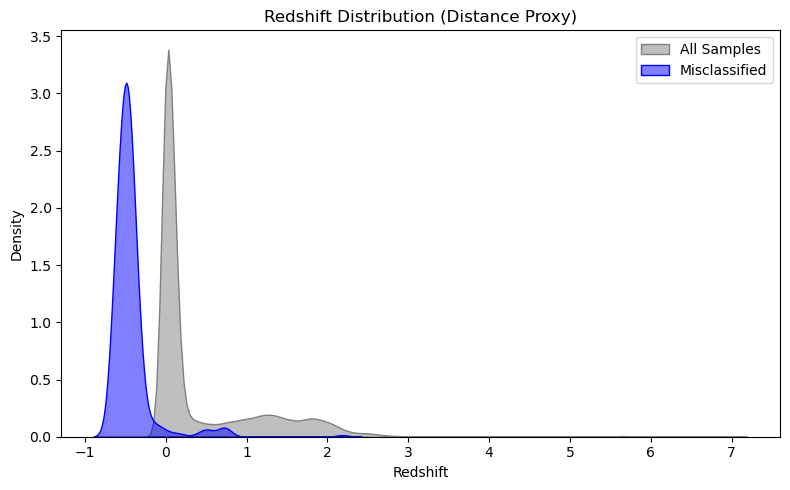

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')  # 🚫 Hide warnings
df_all = pd.read_csv("augmented_SDSS.csv")
df_wrong = pd.read_csv(r"C:\Users\kuzey\OneDrive\Masaüstü\fizik_proje\wrong_predictions.csv")

label_map = {0: "STAR", 1: "GALAXY", 2: "QSO"}
df_all["label_name"] = df_all["label"].map(label_map)
df_wrong["true_name"] = df_wrong["true"].map(label_map)

plt.figure(figsize=(8,5))
sns.kdeplot(df_all['r'], label="All Samples", fill=True, color='gray', alpha=0.5)
sns.kdeplot(df_wrong['r'], label="Misclassified", fill=True, color='red', alpha=0.5)
plt.title("r-band Brightness Distribution")
plt.xlabel("r Magnitude (lower = brighter)")
plt.legend()
plt.tight_layout()
plt.show()

df_all['color_gr'] = df_all['g'] - df_all['r']
df_wrong['color_gr'] = df_wrong['g'] - df_wrong['r']

plt.figure(figsize=(8,5))
sns.kdeplot(df_all['color_gr'], label="All Samples", fill=True, color='gray', alpha=0.5)
sns.kdeplot(df_wrong['color_gr'], label="Misclassified", fill=True, color='orange', alpha=0.5)
plt.title("Color Distribution (g - r)")
plt.xlabel("Color Index (g - r)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
sns.kdeplot(df_all['redshift'], label="All Samples", fill=True, color='gray', alpha=0.5)
sns.kdeplot(df_wrong['redshift'], label="Misclassified", fill=True, color='blue', alpha=0.5)
plt.title("Redshift Distribution (Distance Proxy)")
plt.xlabel("Redshift")
plt.legend()
plt.tight_layout()
plt.show()
